# Read a Veg Plot

In [1]:
from os import path
import math
import s3fs
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
s3 = s3fs.S3FileSystem(anon=False)
files = s3.ls('bioscape-data/')
files

['bioscape-data/AVNG',
 'bioscape-data/BioSCapeVegPolys2023_10_18',
 'bioscape-data/BioSCapeVegPolys2023_10_18.parquet',
 'bioscape-data/LVIS',
 'bioscape-data/PRISM',
 'bioscape-data/bioscape_avng.yaml']

In [3]:
vegpoly_gdf = gpd.read_parquet(path.join('s3://', 'bioscape-data/BioSCapeVegPolys2023_10_18.parquet'))
vegpoly_gdf[:1]

,BScpPID,Region,Name,Dscrptn,DateTim,data_path,geometry
0,T171,Cederberg,Cederberg 171 polygon,None,03 May 2023 at 13:12:34,[s3://bioscape-data/BioSCapeVegPolys2023_10_18...,"MULTIPOLYGON (((19.02606 -32.15087, 19.02607 -..."


<Axes: >

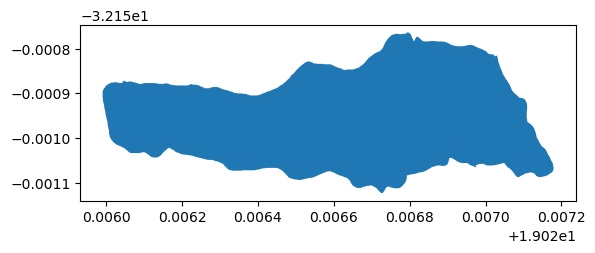

In [4]:
vegpoly_gdf[:1].plot()

In [5]:
# subset aviris-ng files
avirs_subf = vegpoly_gdf[:1]['data_path'][0]
avirs_subf

array(['s3://bioscape-data/BioSCapeVegPolys2023_10_18/Cederberg_T171/ang20231026t113418_002.nc',
       's3://bioscape-data/BioSCapeVegPolys2023_10_18/Cederberg_T171/ang20231026t114327_021.nc',
       's3://bioscape-data/BioSCapeVegPolys2023_10_18/Cederberg_T171/ang20231028t123326_003.nc',
       's3://bioscape-data/BioSCapeVegPolys2023_10_18/Cederberg_T171/ang20231028t123326_004.nc',
       's3://bioscape-data/BioSCapeVegPolys2023_10_18/Cederberg_T171/ang20231112t100920_004.nc',
       's3://bioscape-data/BioSCapeVegPolys2023_10_18/Cederberg_T171/ang20231112t101817_021.nc'],
      dtype=object)

In [6]:
# print structure of one file
with s3.open(avirs_subf[3]) as infile:
    ds = xr.open_dataset(infile, engine='h5netcdf', decode_coords="all")
ds

<xarray.Dataset> Size: 400kB
Dimensions:      (wavelength: 425, x: 26, y: 9)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
  * x            (x) float64 208B 3.138e+05 3.138e+05 ... 3.139e+05 3.139e+05
  * y            (y) float64 72B 6.441e+06 6.441e+06 ... 6.441e+06 6.441e+06
    spatial_ref  int64 8B ...
Data variables:
    reflectance  (y, wavelength, x) float32 398kB ...

/home/conda/global/ed915856-1721679220-2-BioSCape/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


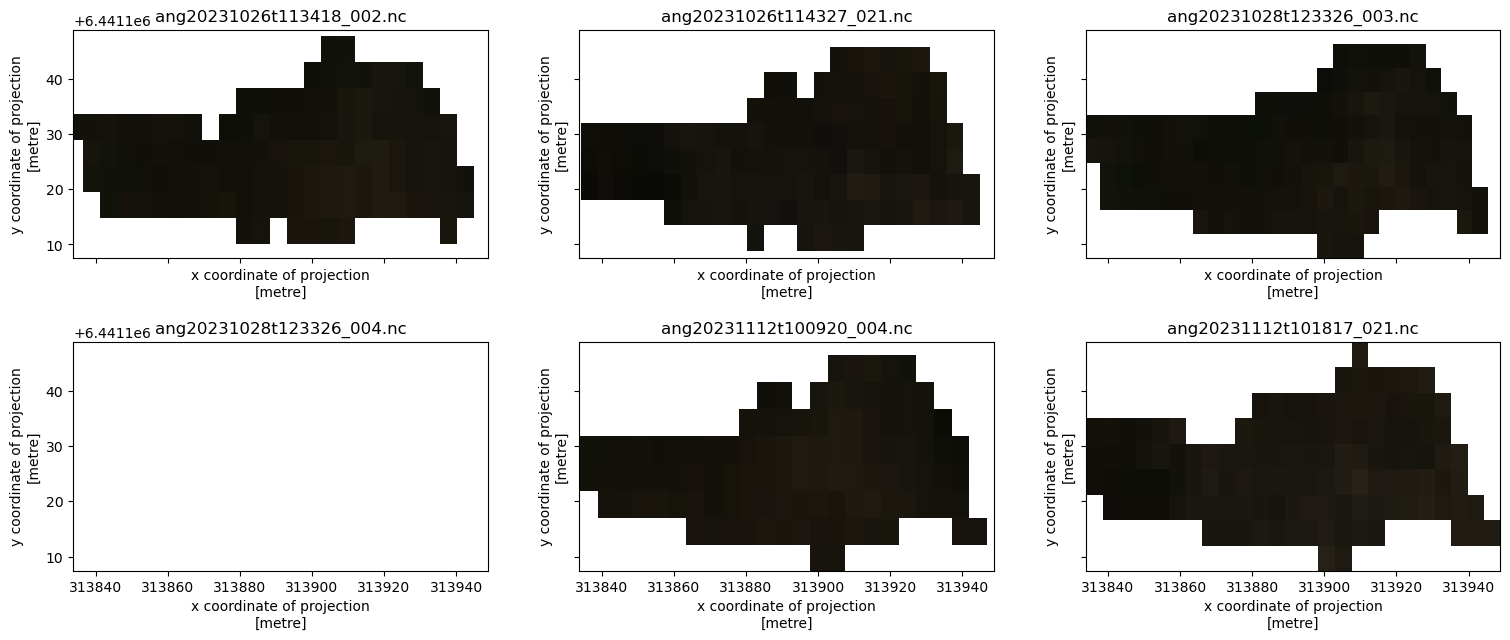

In [7]:
# plot subset avrisng files
nfiles = len(avirs_subf)
nrows = int(math.ceil(nfiles / 3))
fig, ax = plt.subplots(nrows=nrows, ncols=3, sharex=True, sharey=True, figsize=(15, 6))
fig.tight_layout(h_pad=5, w_pad=5)
n = 0
for row in ax:
    for col in row:
        with s3.open(avirs_subf[n]) as infile:
            ds = xr.open_dataset(infile, engine='h5netcdf', decode_coords="all")
            ds_reflectance = ds['reflectance'].isel(wavelength=[57, 38, 22]).transpose('y', 'x', 'wavelength')
            ds_reflectance.plot.imshow(rgb="wavelength", ax=col)
            col.set_title(path.basename(avirs_subf[n]))
            n+=1
plt.show()

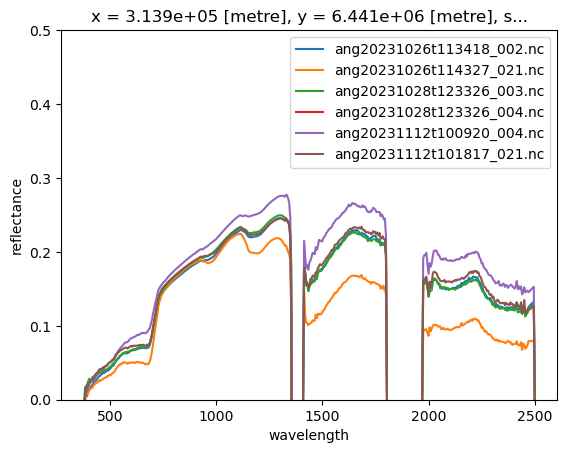

In [8]:
# plot spectra of a pixel from all AVIRIS-NG subsets
for i, infile in enumerate(avirs_subf):
    with s3.open(infile) as infile:
        ds = xr.open_dataset(infile, engine='h5netcdf', decode_coords="all")
        ds.isel(y=5, x=5).reflectance.plot.line(ylim=(0,.5), label=path.basename(avirs_subf[i])) 

plt.legend()
plt.show()